# PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learnt on another dataset and applying to our own porblem.

* Pretrained model = foundation model

In [1]:
import torch 
import torchvision


device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.__version__)
print(torchvision.__version__)
device

2.2.0+cu121
0.17.0+cu121


'cuda'

In [2]:
from torchinfo import summary

## 1. Get data

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food01 dataset

# If the image folder doesn't exist, download it and preprare it... 
if image_path.is_dir():
    print(f"{image_path} already exists, skipping re-download.")
else:
    print(f"Did not find {image_path}, downloading it...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi already exists, skipping re-download.


## 2. Create Datasets and DataLoaders

## 2.1 Creating a transform for torchvision.models (manual creation)

torchvision.models contains pretrained models (models ready for transfer learning) right within torchvision.

In [4]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, .456, 0.406],
                                std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [5]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
from going_modular import data_setup, engine

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21473bfe5a0>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating a transform for `torchvision.models` (automatically)

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" best available weights

weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create DataLoaders using automatic transforms
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=auto_transforms,
                                                                              batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21473bfec90>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models accross different problem spaces/domains)


## 3.1 Which pre-trained model should we use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed (How fast does it run?)
2. Size (How big is the model?)
3. Performance (How well does it go on our chosen problem)

## 3.2 Setting up a pretrained model

In [11]:
# OLD mehtod of creating a pre-trained model (prior to torchvision <v.0.13)
old_model = torchvision.models.efficientnet_b0(pretrained=True)

# New Method of creating a pre-trained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

C:\Users\Jamshid\Desktop\pytorch\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jamshid\Desktop\pytorch\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## 3.3 Getting a summary of our model with `torchinfo.summary()`

In [13]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically We'll "freeze" the base layers of a pretrained/foundation model and update the output layers to suit our own problem.


In [14]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [15]:
# Update the classifier head of our model to suit our problem

from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
             out_features=len(class_names)).to(device) # our problem has 3 classes; pizza, steak, sushi
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [16]:
summary(model=model,
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Import train function
from going_modular import engine

#Start timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5,
                      device=device)

# End the tiemr and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|████████████████▊                                                                   | 1/5 [00:11<00:46, 11.65s/it]

Epoch: 1 | train_loss: 0.5028 | train_acc: 0.8047 | test_loss: 0.4420 | test_acc: 0.8655


 40%|█████████████████████████████████▌                                                  | 2/5 [00:23<00:34, 11.52s/it]

Epoch: 2 | train_loss: 0.4325 | train_acc: 0.8398 | test_loss: 0.4294 | test_acc: 0.9062


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:34<00:23, 11.50s/it]

Epoch: 3 | train_loss: 0.4323 | train_acc: 0.8438 | test_loss: 0.4185 | test_acc: 0.8750


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:46<00:11, 11.50s/it]

Epoch: 4 | train_loss: 0.4101 | train_acc: 0.8359 | test_loss: 0.4142 | test_acc: 0.8864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.55s/it]

Epoch: 5 | train_loss: 0.4542 | train_acc: 0.8281 | test_loss: 0.4420 | test_acc: 0.8561
[INFO] Total training time: 57.765 seconds


In [21]:
results

{'train_loss': [0.5027815252542496,
  0.4324900358915329,
  0.43230124562978745,
  0.4101046063005924,
  0.4542306177318096],
 'train_acc': [0.8046875, 0.83984375, 0.84375, 0.8359375, 0.828125],
 'test_loss': [0.4420496126015981,
  0.42940913637479144,
  0.41845173637072247,
  0.4142426351706187,
  0.44197772939999896],
 'test_acc': [0.8655303030303031,
  0.90625,
  0.875,
  0.8863636363636364,
  0.8560606060606061]}

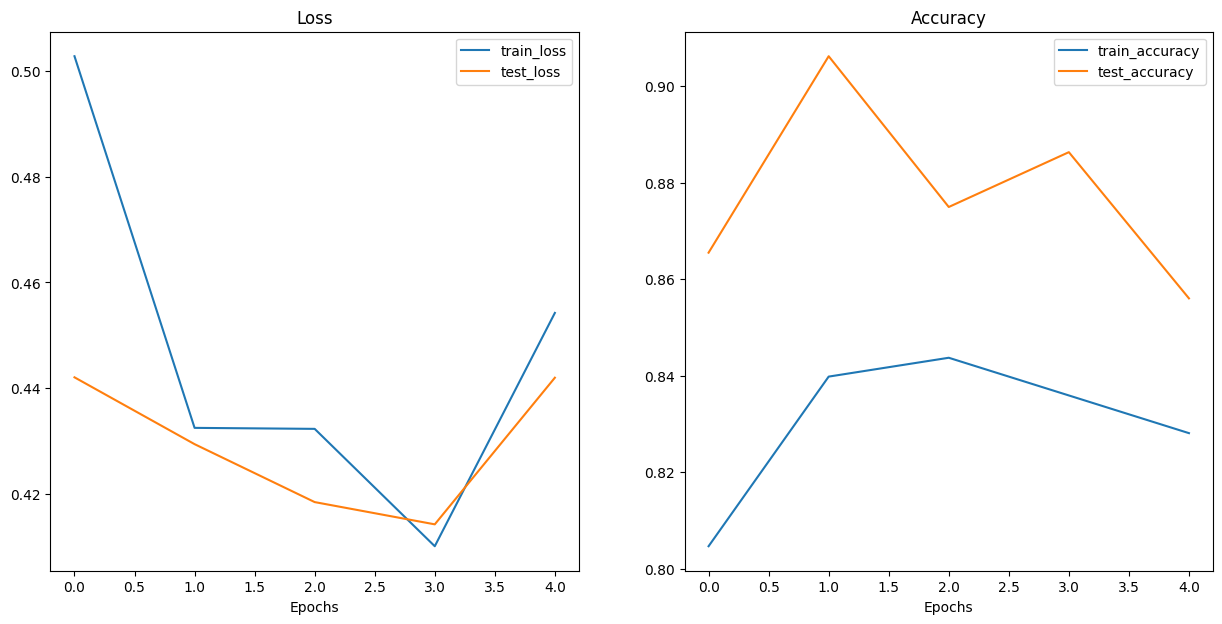

In [24]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 5. Make predictions on the images from the test set

In [44]:
from typing import List, Tuple
import matplotlib.pyplot as plt

from PIL import Image

# Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device = device):
    # 2. Open the image with PIL
    img = Image.open(image_path)

    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, .456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
    ### Predict on image ###
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6.Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on the transformed image by passing it to the model
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert the model's output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Covert the model's pred probs to pred labes
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [45]:
test_dir

WindowsPath('data/pizza_steak_sushi/test')

In [46]:
class_names

['pizza', 'steak', 'sushi']

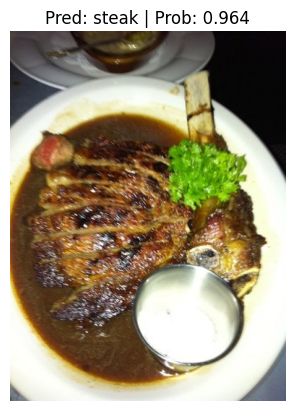

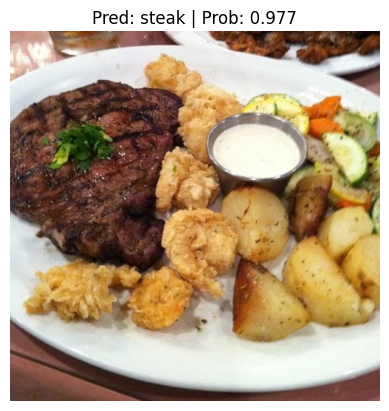

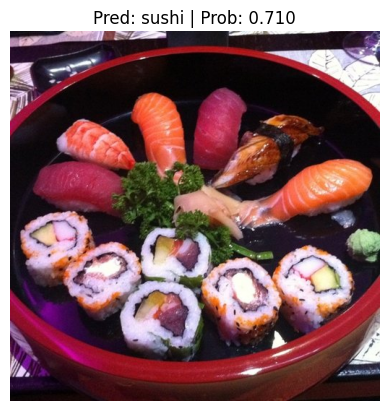

In [50]:
# Get random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                      k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                       image_path=image_path,
                       class_names=class_names,
                       image_size=(224, 224))

## 6.1 Making predictions on a custom image

In [54]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza_grandpa_img.jpg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # Download any image from the internet
        request = requests.get("https://brooklynreporter.com/wp-content/uploads/2022/03/pic-15-976x1024.jpg")
        print(f"Download {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download")

Download data\pizza_grandpa_img.jpg...


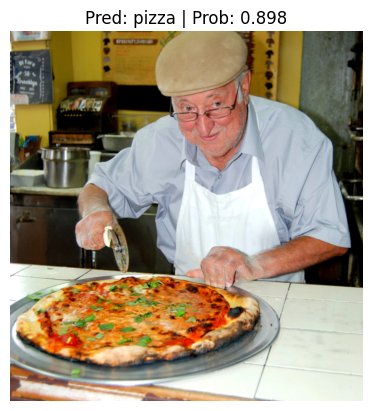

In [55]:
# Predict on custom image
pred_and_plot_image(model=model,
                   image_path=custom_image_path,
                   class_names=class_names)